# TRAINING A CLASSIFIER
[Pytorch:60分钟深度学习系列教程之4 训练一个分类器（数据集CIFAR-10）](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import traceback

数据一般加载到numpy中再转换为Tensor

* For images, packages such as Pillow, OpenCV are useful
* For audio, packages such as scipy and librosa
* For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

对于计算机视觉, torch 有个包 torchvision.可以方便地加载通用据集, 如 ImageNet, CIFAR10, MNIST等.

# Classifier

## 加载数据集

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 训练集
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

# 数据加载器
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True,
    num_workers=2)  # num_workers 2 个线程加载数据

# 测试集
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


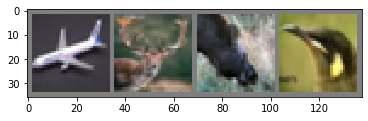

plane  deer  deer  bird


In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # 原来 3 * (24*mini_batch_size) *(24*mini_batch_size), 把维度 换成 (24*mini_batch_size) * (24*mini_batch_size * 3)
    plt.show()


# 随机获取一些数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))  #多张图拼成一张图

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## CNN

In [4]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)  # 5x5

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
#         x = x.view(-1, self.num_flat_features(x))
        # hard code
        x = x.view(-1,400) #16 * 5 * 5

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一个不用激活？计算10个分类的可能性
        return x

    def num_flat_features(self, x):
        '''
        对于不固定的输入,可以使用这个函数, 这里的输入是固定的,直接hard code
        '''
        with torch.no_grad():
            size = x.size()[1:]  # 第0维是batch size，后面是特征维度
            num_features = 1
            for s in size:
                num_features *= s
            return num_features

           
class LeNet_3(nn.Module):
    def __init__(self):
        super(LeNet_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)  # 3x3
        self.conv2 = nn.Conv2d(6, 16, 3)  # 3x3

        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # max pool 2 2x2
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # 二维矩阵 转 向量
#         x = x.view(-1, self.num_flat_features(x))
        x = x.view(-1,576) #16 * 6 * 6

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 最后一个不用激活？计算10个分类的可能性
        return x

    def num_flat_features(self, x):
        '''
        对于不固定的输入,可以使用这个函数, 这里的输入是固定的,直接hard code
        '''
        with torch.no_grad():
            size = x.size()[1:]  # 第0维是batch size，后面是特征维度
            num_features = 1
            for s in size:
                num_features *= s
            return num_features

In [5]:
# GPU
# model to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = LeNet_3()
net.to(device)

cuda:0


LeNet_3(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

这个LeNet-5 分类器, 可以用于各种分类任务

只需要修改conv1 和 fc1 fc3 的结构, 能应用于各种输入 输出

## Loss and optimizer 

In [6]:
criterion = nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 动量

## Train

In [7]:
for epoch in range(2):  # 数据集的循环次数, 相当于每个数据, 会训练两次

    running_loss = 0.0  # 运行时的损失的值(2000次loss的均值),记录损失的下降趋势
    for i, data in enumerate(trainloader, 0):  # enumerate(sequence, [start=0])
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device) #GPU
    
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)  # 最后得到一个标量,loss
        loss.backward()

        optimizer.step()  # 这里更新了参数

        running_loss += loss.item()  # Tensor.item() 得到标量的值, 非标量不能调用

        # log statistics
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.253
[1,  4000] loss: 1.963
[1,  6000] loss: 1.747
[1,  8000] loss: 1.607
[1, 10000] loss: 1.531
[1, 12000] loss: 1.488
[2,  2000] loss: 1.394
[2,  4000] loss: 1.357
[2,  6000] loss: 1.323
[2,  8000] loss: 1.301
[2, 10000] loss: 1.278
[2, 12000] loss: 1.265
Finished Training


## Test

### 来几个样本看看

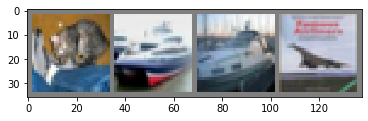

GroundTruth:    cat  ship  ship plane


In [8]:
# 来几个样本看看
dataiter = iter(testloader)
data = dataiter.next()

# ground truth
# print images
imshow(torchvision.utils.make_grid(data[0]))

images, labels = data[0].to(device), data[1].to(device) #GPU



print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
# predict
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


### 统计准确率

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device) #GPU
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


调参

学习率0.01, 损失一直不下降, 2次迭代测试集准确率26%
学习率0.001, 准确率 55%

### 不同类别的准确率

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
#         images, labels = data
        images, labels = data[0].to(device), data[1].to(device) #GPU
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 68 %
Accuracy of  bird : 56 %
Accuracy of   cat : 30 %
Accuracy of  deer : 48 %
Accuracy of   dog : 45 %
Accuracy of  frog : 55 %
Accuracy of horse : 49 %
Accuracy of  ship : 72 %
Accuracy of truck : 63 %


## GPU

model(params)和data都要迁移到GPU上才能运算

In [12]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)
# net.to(device)
# inputs, labels = data[0].to(device), data[1].to(device)